In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from xgboost import plot_importance
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load Data
train_df = pd.read_csv("../input/playground-series-s4e5/train.csv")
test_df = pd.read_csv("../input/playground-series-s4e5/test.csv")

In [4]:
# test_df.head()

In [5]:
# print(train_df.head())
# display(train_df.columns)

In [6]:
# train_df.dtypes

In [7]:
# train_df.isna().any()

In [8]:
# plt.figure(figsize=(20, 20))
# sns.heatmap(train_df.corr(), vmax=1, vmin=-1, cmap='RdBu', annot=True)

In [9]:
# train_df.hist(figsize=(20, 20), xrot=-45)
# plt.show()

In [10]:
# train_df.nunique()

In [11]:
# train_df.shape

Notes:

1. There are no missing values

2. The data is made of 21 categorical columns that are already encoded as integers and a label column in float

3. The distribution of the columns is a guassian distribution

4. There's no significant correlation between the features.

In [12]:
X = train_df.drop(['FloodProbability', 'id'], axis = 1)
y = train_df['FloodProbability']

In [13]:
# Split data into training and test sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Mutual Information

from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
def drop_uninformative(df, mi_scores, threshold):
    return df.loc[:, mi_scores > threshold]

In [15]:
# mi_scores = make_mi_scores(X, y)

In [16]:
# plt.figure(dpi=100, figsize=(8, 5))
# plot_mi_scores(mi_scores)

In [17]:
# from sklearn.model_selection import cross_val_score

# def score_dataset(X, y, model=XGBRegressor(n_jobs=4, verbosity=2, random_state=1)):
    
#     score = cross_val_score(
#         model, X, y, cv=5, scoring="r2",
#     )
#     score = score.mean()
#     score = np.sqrt(score)
#     return score

In [18]:
def score_valid(X_train, y_train, X_valid, y_valid):
    model=XGBRegressor(n_jobs=4, verbosity=2, random_state=1, early_stopping_rounds = 5)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose = False)
    y_pred = model.predict(X_valid)
    r2 = r2_score(y_valid, y_pred)
    print(f"R2 Score: {r2}")
    # Get feature importances
    importances = model.feature_importances_
    print(importances)
    
    # Plot feature importances
    plot_importance(model)
    plt.show()
    return model

In [19]:
def score_data(X, y):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
    return score_valid(X_train, y_train, X_valid, y_valid)
    

In [20]:
# score_dataset(X, y)

In [21]:
# score_valid(X_train, y_train, X_valid, y_valid)

In [22]:
# from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures(degree=2)
# X_poly_train = poly.fit_transform(X)
# X_t, X_v, y_t, y_v = train_test_split(X_poly_train, y, test_size=0.2, random_state=42)
# score_valid(X_t, y_t, X_v, y_v)


In [23]:
# score_dataset(X_poly_train, y)

In [24]:
df = train_df.copy()
df = df.drop(['FloodProbability', 'id'],axis = 1)

In [25]:
def generate_features(dataset):
    features = ['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors']
    
    
    dataset['mean_features'] = 0.1*dataset[features].mean(axis=1)
    dataset['std_features'] = dataset[features].std(axis=1)
    dataset['max_features'] = dataset[features].max(axis=1)
    #dataset['min_features'] = dataset[features].min(axis=1)
    dataset['median_features'] = 0.1*dataset[features].median(axis=1)
    #dataset['range_features'] = dataset['max_features'] - dataset['min_features']
    dataset['variance_features'] = dataset[features].var(axis=1)
    dataset['skewness_features'] = dataset[features].skew(axis=1)
    
    quartiles = dataset[features].quantile([0.25, 0.5, 0.75], axis=1)
    dataset['first_quartile'] = quartiles.loc[0.25]
    dataset['second_quartile'] = quartiles.loc[0.5]
    dataset['third_quartile'] = quartiles.loc[0.75]
    
    kurtosis_features = dataset[features].kurtosis(axis=1)
    dataset['kurtosis_features'] = kurtosis_features
    
    selected_columns = ['Urbanization', 'Deforestation', 'AgriculturalPractices', 'InadequatePlanning']
    dataset['Sum_Selected_Columns'] = dataset[selected_columns].sum(axis=1)
    
    dataset['Urbanization_Deforestation_Interaction'] = dataset['Urbanization'] * dataset['Deforestation']
    dataset['Urbanization_TopographyDrainage_Ratio'] = dataset['Urbanization'] / (dataset['TopographyDrainage'] + 1)
    
    dataset.drop(features, axis=1, inplace=True)
    
    return dataset

In [26]:
new_df = generate_features(df)

In [27]:
t_df = test_df.copy()
new_test = generate_features(t_df)

R2 Score: 0.8686747817972831
[9.8416674e-01 2.1013201e-03 7.7231522e-03 9.5812400e-04 0.0000000e+00
 1.1165113e-03 8.6015038e-04 0.0000000e+00 1.1745683e-03 5.6146667e-04
 4.6146908e-04 4.9592723e-04 3.8046174e-04]


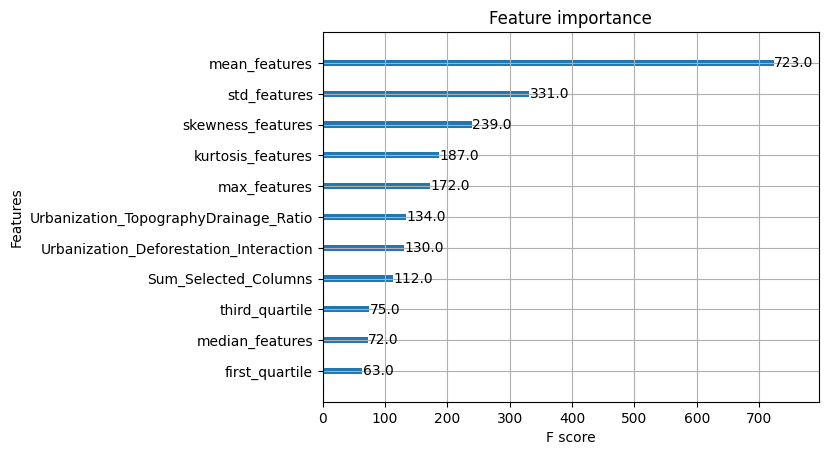

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=4,
             num_parallel_tree=None, random_state=1, ...)

In [28]:
score_data(new_df, y)

In [29]:
# score_dataset(new_df, y)

In [30]:
mi_scores = make_mi_scores(new_df, y)

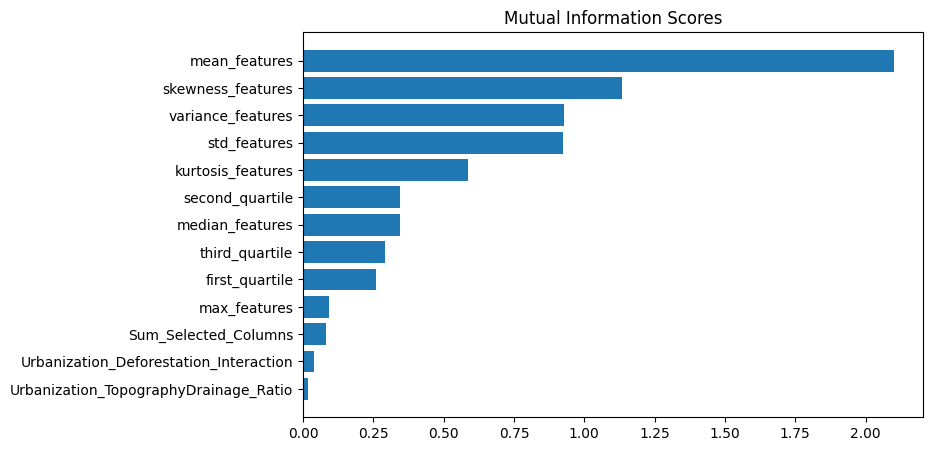

In [31]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [32]:
new_df = drop_uninformative(new_df, mi_scores, 0.5)

In [33]:
new_test = new_test[new_df.columns]

In [34]:
from sklearn.decomposition import PCA
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

In [35]:
pca, X_pca, loadings = apply_pca(X, standardize=False)

R2 Score: 0.8609353732802845
[0.00555527 0.00165933 0.00405976 0.00361131 0.00300624 0.00122981
 0.00306664 0.00113041 0.00136847 0.00453994 0.00172207 0.0021993
 0.00153338 0.00116909 0.00446385 0.00142869 0.00238202 0.00503716
 0.00530078 0.94553643]


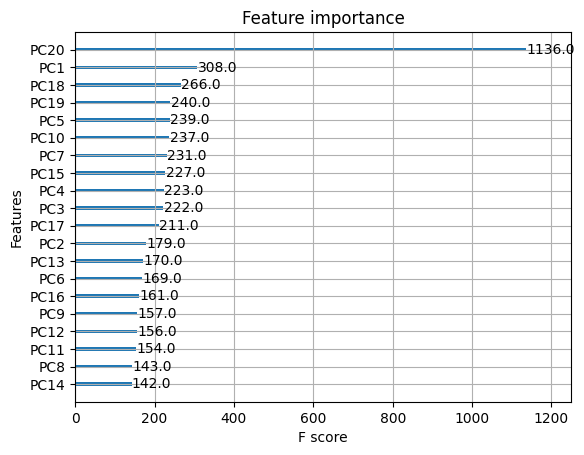

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=4,
             num_parallel_tree=None, random_state=1, ...)

In [36]:
score_data(X_pca, y)

In [37]:
new_df['pc'] = X_pca["PC20"]

/tmp/ipykernel_18/1011094970.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['pc'] = X_pca["PC20"]


In [38]:
Z = test_df.drop(['id'], axis = 1)
Z_pca = pca.transform(Z)
component_names = [f"PC{i+1}" for i in range(Z_pca.shape[1])]
Z_pca = pd.DataFrame(Z_pca, columns=component_names)
new_test['pc'] = Z_pca["PC20"]

/tmp/ipykernel_18/3397487742.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_test['pc'] = Z_pca["PC20"]


In [39]:
# mi_scores = make_mi_scores(X_pca, y)
# plt.figure(dpi=100, figsize=(8, 5))
# plot_mi_scores(mi_scores)


In [40]:
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=15, n_init=10, random_state=0)
# X_cd = kmeans.fit_transform(new_df)


# # Label features and join to dataset
# X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
# X_c = new_df.join(X_cd)


# XGBoost Grid Search

In [41]:
# # Initialize XGBoost regressor
# xgb_reg = XGBRegressor(n_jobs=4, random_state=1, early_stopping_rounds = 5, verbosity=2)

# # Define hyperparameters grid for Grid Search
# param_grid = {
#     'alpha': [0, 0.1, 0.5, 1, 2], 
#     'lambda': [0, 0.1, 0.5, 1, 2],  
#     'learning_rate': [0.001, 0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'n_estimators': [50, 100, 200, 400]
# }

# # Initialize Grid Search with cross-validation
# grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=3, scoring='r2', verbose = 1)

# # Perform Grid Search to find the best hyperparameters
# fit_params = {
#     'eval_set': [(X_valid, y_valid)],
#     'verbose': True
# }
# grid_search.fit(X_train, y_train, **fit_params)

In [42]:
# # Get the best hyperparameters
# best_params = grid_search.best_params_

# # Train XGBoost regressor with the best hyperparameters
# best_xgb_reg = XGBRegressor(n_jobs=4, random_state=1, early_stopping_rounds = 5, verbosity=2, **best_params)
# best_xgb_reg.fit(X_train, y_train, **fit_params)

# # Predict on the test set
# y_pred = best_xgb_reg.predict(X_valid)

# # Calculate R² score on the test set
# r2 = r2_score(y_valid, y_pred)
# print("R² Score:", r2)

In [43]:
# # best grid search param

# # Get the best estimator and evaluate on the validation set
# best_grid_reg = grid_search.best_estimator_
# y_pred_2 = best_grid_reg.predict(X_valid)

# # Calculate R² score
# from sklearn.metrics import r2_score
# r2 = r2_score(y_valid, y_pred_2)
# print("R² Score on Validation Set:", r2)


# Submission

In [44]:
#Sample model
model=XGBRegressor(n_jobs=4, verbosity=2, random_state=1, n_estimators=1000)
model.fit(new_df, y, verbose = False)
y_pred = model.predict(new_test)

In [45]:
sub = pd.read_csv('/kaggle/input/playground-series-s4e5/sample_submission.csv')

In [46]:
sub['FloodProbability'] = y_pred

In [47]:
sub.to_csv("submission.csv", index=False)